# Cyclones: Exploratory Analysis

In [7]:
# %matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime 
import seaborn as sns
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [8]:
full_df = pd.read_csv('../cyclone_data/with_ids_full.csv')

# NOTE: LAT_TENTH IN THE DATAFRAME IS UNSIGNED

def lat_long_string_to_float(s):
    num = s.rstrip('NWES')
    tail = s[len(num):]

    if tail == 'S' or tail == 'W':
        return -float(num)/10
    return float(num)/10


full_df['longitude'] = full_df.loc[:,'Lon'].apply(lat_long_string_to_float)
full_df['longitude'] = full_df.loc[:, 'longitude'].apply(lambda x: x if x > 0 else 360 + x)
full_df['latitude'] = full_df.loc[:, 'Lat'].apply(lat_long_string_to_float)

# transform our latitude to overflow past 180 as we are interested in the eastern hemisphere

In [9]:
# only take a subset of columns for now
relevant_df = full_df.loc[:,["id", "Time", "latitude", "longitude", "Speed(knots)"]]
relevant_df['Year'] = relevant_df.loc[:,'Time'].apply(lambda dt: float(datetime.strptime(dt, '%Y-%m-%d %X').year))
relevant_df
# NOTE: why is there a cyclone in July? is this a data error?

,id,Time,latitude,longitude,Speed(knots),Year
0,1,1981-07-25 12:00:00,-11.8,86.7,20,1981.0
1,1,1981-07-25 18:00:00,-11.6,86.4,25,1981.0
2,1,1981-07-26 00:00:00,-11.3,86.2,25,1981.0
3,1,1981-07-26 06:00:00,-10.9,86.2,25,1981.0
4,1,1981-07-26 12:00:00,-10.4,86.1,25,1981.0
...,...,...,...,...,...,...
30559,1002,2019-05-17 00:00:00,-9.9,134.0,25,2019.0
30560,1002,2019-05-17 06:00:00,-9.6,132.7,20,2019.0
30561,1002,2019-05-17 12:00:00,-8.8,131.8,20,2019.0
30562,1002,2019-05-17 18:00:00,-8.4,130.8,20,2019.0


###  South Indian: What have we been seeing?

###  Has cyclone intensity been increasing?

In [10]:
def kmh_to_knots(kmh):
    return kmh * 0.539957

def get_category(wind_speed_kn):
    if wind_speed_kn < kmh_to_knots(125):
        return 1
    if wind_speed_kn < kmh_to_knots(164):
        return 2
    if wind_speed_kn < kmh_to_knots(224):
        return 3
    if wind_speed_kn < kmh_to_knots(279):
        return 4
    
    return 5
    
    

In [11]:
relevant_df['Peak Wind'] = relevant_df.groupby('id')['Speed(knots)'].transform('max')

In [12]:
relevant_df['Category'] = relevant_df.loc[:,'Peak Wind'].apply(lambda wind_speed: get_category(wind_speed))

<Axes: xlabel='Year', ylabel='Count'>

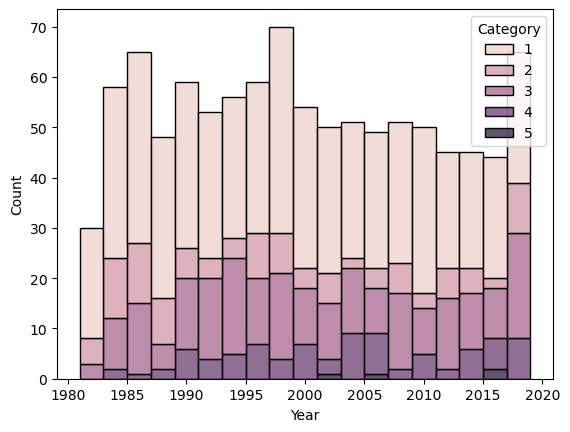

In [34]:
one_per_id = relevant_df.drop_duplicates(subset='id')
sns.histplot(one_per_id, x='Year', hue='Category', multiple="stack", binwidth=2)
# do not see any strong trend

<Axes: xlabel='Year', ylabel='Count'>

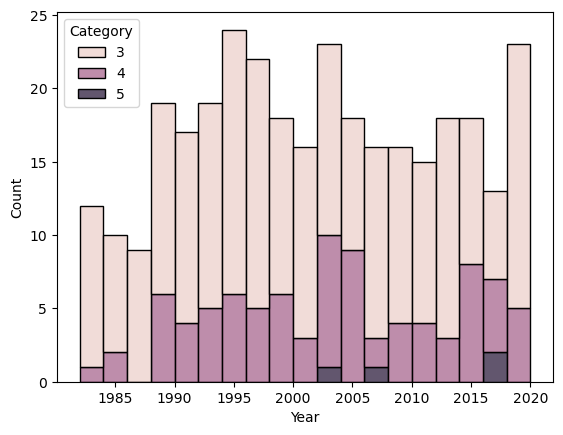

In [33]:
# bit of noise in the cat 1s and 2s so we'll filter them out
one_per_id_severe = one_per_id.loc[one_per_id.loc[:, 'Category'] >= 3]
sns.histplot(one_per_id_severe, x='Year', hue='Category', multiple="stack", binwidth=2)

### Expressing this in terms of accumulated Cyclone energy

In [15]:
irrelevant_df = relevant_df.copy()
irrelevant_df['Wind speed (kn2)'] = irrelevant_df['Speed(knots)'].apply(lambda x: x * x)
irrelevant_df['Yearly ACE'] = irrelevant_df.groupby('Year')['Wind speed (kn2)'].transform('sum') / 10000
irrelevant_df



,id,Time,latitude,longitude,Speed(knots),Year,Peak Wind,Category,Wind speed (kn2),Yearly ACE
0,1,1981-07-25 12:00:00,-11.8,86.7,20,1981.0,30,1,400,24.9300
1,1,1981-07-25 18:00:00,-11.6,86.4,25,1981.0,30,1,625,24.9300
2,1,1981-07-26 00:00:00,-11.3,86.2,25,1981.0,30,1,625,24.9300
3,1,1981-07-26 06:00:00,-10.9,86.2,25,1981.0,30,1,625,24.9300
4,1,1981-07-26 12:00:00,-10.4,86.1,25,1981.0,30,1,625,24.9300
...,...,...,...,...,...,...,...,...,...,...
30559,1002,2019-05-17 00:00:00,-9.9,134.0,25,2019.0,60,1,625,235.9275
30560,1002,2019-05-17 06:00:00,-9.6,132.7,20,2019.0,60,1,400,235.9275
30561,1002,2019-05-17 12:00:00,-8.8,131.8,20,2019.0,60,1,400,235.9275
30562,1002,2019-05-17 18:00:00,-8.4,130.8,20,2019.0,60,1,400,235.9275


/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_88961/638427780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unq['Rolling'] = unq.loc[:,'Yearly ACE'].ewm(span = 1).mean()


<Axes: xlabel='Year', ylabel='Rolling'>

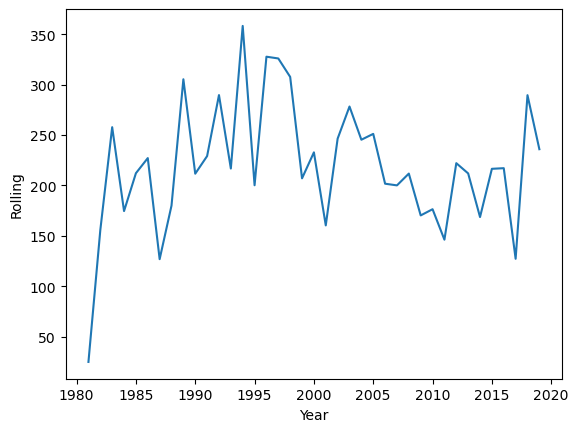

In [40]:
unq = irrelevant_df.drop_duplicates(subset='Year')
unq['Rolling'] = unq.loc[:,'Yearly ACE'].ewm(span = 1).mean()
sns.lineplot(x="Year", y="Rolling", data=unq)

## High category Cyclonee: where have they occurred?

<Axes: xlabel='Category', ylabel='Count'>

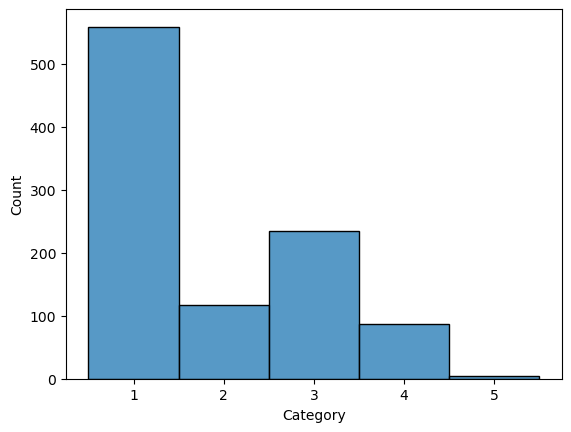

In [17]:
sns.histplot(one_per_id, x='Category', discrete=True)



In [18]:
severe_cyclones = relevant_df.loc[relevant_df.loc[:, 'Category'] >= 3]
severe_one_per_id = severe_cyclones.drop_duplicates(subset='id')
severe_one_per_id.shape[0] ## TOTAL OF 326 Cyclones >= category 3

326

In [19]:
## only show origin sites for now
min_long = severe_one_per_id['longitude'].min()
min_lat = severe_one_per_id['latitude'].min()

max_long = severe_one_per_id['longitude'].max()
max_lat = severe_one_per_id['latitude'].max()

print('latitude: ' + str(min_lat) + ' to ' + str(max_lat))
print('longitude: ' + str(min_long) + ' to ' + str(max_long))

latitude: -28.2 to 1.9
longitude: 37.4 to 227.2


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, *

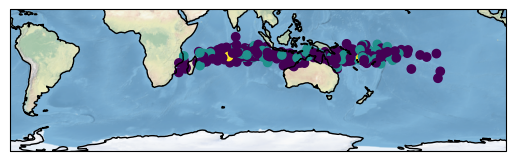

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= (max_long-min_long)/2))
ax.set_extent([min_long, max_long ,min_lat,max_lat])
ax.coastlines()
ax.stock_img()

colours = ['red', 'orange', 'green']

plt.scatter(x=severe_one_per_id['longitude'], y=severe_one_per_id['latitude'], cmap='viridis',c=severe_one_per_id['Category'], transform=ccrs.PlateCarree())

plt.show()

### Tracks of the category 5s

In [21]:
cat_5s = relevant_df.loc[relevant_df.loc[:, 'Category'] == 5].drop_duplicates(subset='id')
cat_5s

,id,Time,latitude,longitude,Speed(knots),Year,Peak Wind,Category
18351,600,2002-12-24 12:00:00,-9.0,181.7,15,2002.0,155,5
21227,695,2006-04-16 18:00:00,-11.1,150.8,25,2006.0,155,5
27998,927,2016-02-09 18:00:00,-13.6,169.5,20,2016.0,155,5
28213,934,2016-04-11 00:00:00,-12.4,73.5,20,2016.0,155,5


In [22]:
# for some reason
# NOTE: this cyclone originated in the south pacific and came into the south indian
zoe_df = relevant_df.loc[relevant_df.loc[:, 'id'] == 600].sort_values(['Time'])
monica_df = relevant_df.loc[relevant_df.loc[:, 'id'] == 695].sort_values(['Time'])
winston_df = relevant_df.loc[relevant_df.loc[:, 'id'] == 927].sort_values(['Time'])
fantala_df = relevant_df.loc[relevant_df.loc[:, 'id'] == 934].sort_values(['Time'])

cat5_dfs = [
    {'df' : zoe_df, 'name': 'Zoe'}, 
    {'df': monica_df, "name": "Monica"}, 
    {"df": winston_df, "name": "Winston"}, 
    {"df": fantala_df, "name": "Fantala"}
]




In [23]:
for dic in cat5_dfs:
    name = dic["name"]  
    df = dic["df"]
    print(name)
    print(f'min long: {df["longitude"].min()}')
    print(f'max long: {df["longitude"].max()}')
    print(f'min lat: {df["latitude"].min()}')
    print(f'max lat: {df["latitude"].max()}')
    print("====================")

Zoe
min long: 169.2
max long: 181.7
min lat: -21.9
max lat: -9.0
Monica
min long: 129.6
max long: 150.8
min lat: -14.2
max lat: -11.1
Winston
min long: 156.3
max long: 189.1
min lat: -27.4
max lat: -13.6
Fantala
min long: 48.2
max long: 73.5
min lat: -13.2
max lat: -7.3


In [24]:
import shapely.geometry as sgeom
track_coords_list = [list(zip(obj["df"].longitude, obj["df"].latitude)) for obj in cat5_dfs]
track_objs = [sgeom.LineString(track_coords) for track_coords in track_coords_list]

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambafo

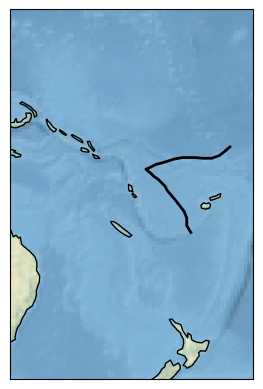

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


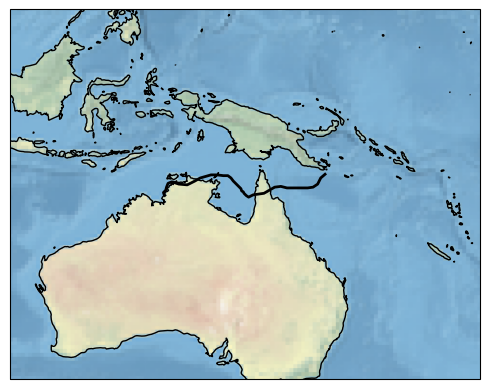

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


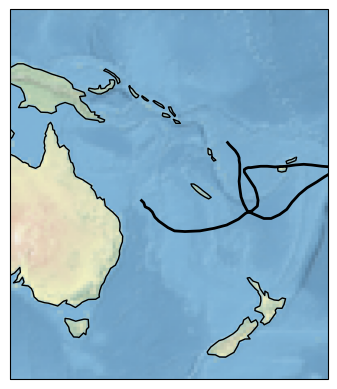

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


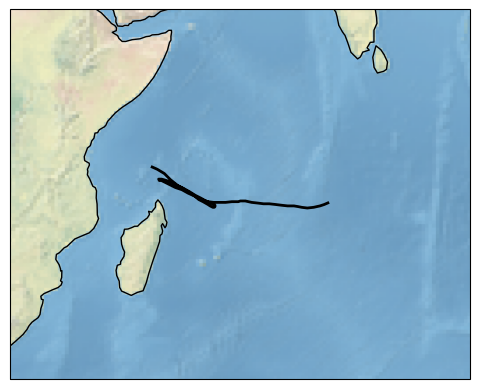

In [25]:
for i in range(len(track_objs)):
    df = cat5_dfs[i]["df"]
    track_obj = track_objs[i]
    name = cat5_dfs[i]["name"]

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(df['longitude'].max() - df['longitude'].min())/2))
    # NOTE: set_extend doesnt like it when we overflow past 180
    ax.set_extent([df['longitude'].min() - 20, min(df['longitude'].max() + 20, 185) ,  df['latitude'].min() -  20, df['latitude'].max() + 20])
    ax.coastlines()
    ax.stock_img()

    colours = ['red', 'orange', 'green']
    ax.add_geometries([track_obj],ccrs.PlateCarree(), facecolor='none', linewidth=2)
    plt.show()
  

## How do cyclones become intense?
Here look at the wind speed trends of cyclones that achieve category 4 and above. 
#### TODO: attempt connection with SSTs when data is obtained  

In [26]:
severe_cyclones['wind_prop'] = severe_cyclones.apply(lambda row: row['Speed(knots)']/row['Peak Wind'], axis=1)
severe_cyclones['initial_time'] = severe_cyclones.groupby('id')['Time'].transform('min')

def diff_in_hours(timedelta):
    SECONDS_IN_HOUR = 3600
    return timedelta.total_seconds()/SECONDS_IN_HOUR

# 2006-04-24 06:00:00
TIME_FORMAT = "%Y-%m-%d %X"
severe_cyclones['elapsed_hours'] = severe_cyclones.apply(lambda row:  diff_in_hours(datetime.strptime(row['Time'], TIME_FORMAT) - datetime.strptime(row['initial_time'], TIME_FORMAT)), axis=1)
severe_cyclones






/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_88961/2932544078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severe_cyclones['wind_prop'] = severe_cyclones.apply(lambda row: row['Speed(knots)']/row['Peak Wind'], axis=1)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_88961/2932544078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severe_cyclones['initial_time'] = severe_cyclones.groupby('id')['Time'].transform('min')
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykern

,id,Time,latitude,longitude,Speed(knots),Year,Peak Wind,Category,wind_prop,initial_time,elapsed_hours
101,6,1982-01-06 00:00:00,-12.7,102.9,20,1982.0,120,3,0.166667,1982-01-06 00:00:00,0.0
102,6,1982-01-06 06:00:00,-12.7,102.4,25,1982.0,120,3,0.208333,1982-01-06 00:00:00,6.0
103,6,1982-01-06 12:00:00,-12.8,101.8,25,1982.0,120,3,0.208333,1982-01-06 00:00:00,12.0
104,6,1982-01-06 18:00:00,-12.9,101.2,25,1982.0,120,3,0.208333,1982-01-06 00:00:00,18.0
105,6,1982-01-07 00:00:00,-13.0,100.4,25,1982.0,120,3,0.208333,1982-01-06 00:00:00,24.0
...,...,...,...,...,...,...,...,...,...,...,...
30507,999,2019-04-29 06:00:00,-20.8,89.1,50,2019.0,90,3,0.555556,2019-04-21 18:00:00,180.0
30508,999,2019-04-29 12:00:00,-21.4,89.0,40,2019.0,90,3,0.444444,2019-04-21 18:00:00,186.0
30509,999,2019-04-29 18:00:00,-21.9,89.0,35,2019.0,90,3,0.388889,2019-04-21 18:00:00,192.0
30510,999,2019-04-30 00:00:00,-22.9,89.1,30,2019.0,90,3,0.333333,2019-04-21 18:00:00,198.0


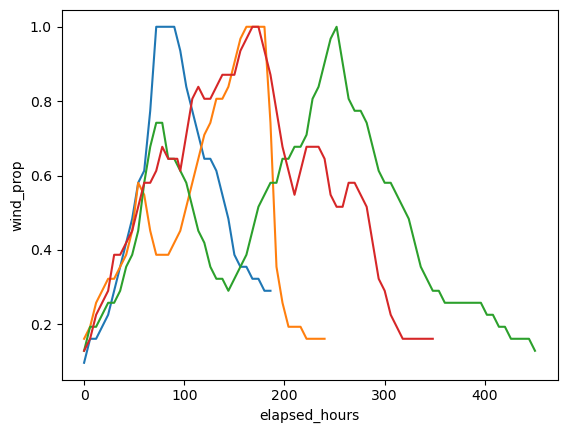

In [27]:
# TODO: investigate link with SSTs when we get more granular data.
#       IN PARTICULAR, INVESTIGATE WHAT OCCURS 
for index, row in cat_5s.iterrows():
    id = row['id']
    df = severe_cyclones.loc[severe_cyclones.loc[:, 'id'] == id].sort_values(['Time'])
    sns.lineplot(x='elapsed_hours', y='wind_prop', data=df)
plt.show()